In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
#import torchviz
import time
import copy

import matplotlib.pyplot as plt

import ase.io

from utils.soap import compute_spherical_expansion_librascal, TorchFrame

from utils import models

torch.set_default_dtype(torch.float64)

In [2]:
torch.cuda.is_available()

False

In [22]:
n_test = 100
n_train = 300

# frames = ase.io.read("data/elpasolites_10590.xyz", f":")
# energies = torch.tensor(np.loadtxt("data/elpasolites_10590_evpa.dat"))


frames = ase.io.read("data/hea_fcc_offlattice_997.xyz", ":")
energies = torch.tensor([frame.info["energy"] for frame in frames])

train_frames = frames[:n_train]
test_frames = frames[-n_test:]

train_energies = energies[:n_train]
test_energies = energies[-n_test:]

train_forces = np.vstack([frame.arrays["forces"] for frame in train_frames])
test_forces = np.vstack([frame.arrays["forces"] for frame in test_frames])

print(f"using {n_train} training frames")

using 300 training frames


In [23]:
global_species = set()
for frame in frames:
    global_species.update(frame.numbers)

global_species = list(map(lambda u: int(u), global_species))

HYPERS_SMALL = {
    "interaction_cutoff": 5.0,
    "max_angular": 6,
    "max_radial": 8,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "compute_gradients": False,
    "expansion_by_species_method": "user defined",
    "global_species": global_species,
}

HYPERS_FROM_PAPER = {
    "interaction_cutoff": 5.0,
    "max_angular": 9,
    "max_radial": 12,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "compute_gradients": False,
    "expansion_by_species_method": "user defined",
    "global_species": global_species,
}

# Validate utilities

In [24]:
# import utils.gap

# def structure_sum(kernel):
#     return utils.gap.common.SumStructureKernel.apply(kernel, test_slices, train_slices)

# rand_kernel = torch.rand((len(test_slices), len(train_slices)), requires_grad=True)
# torch.autograd.gradcheck(structure_sum, rand_kernel, fast_mode=True)

In [48]:
def evaluate_and_plot_model(model, name, file):
    predicted_energies_training_set = model(
        train_spherical_expansions, train_species, train_slices
    )

    predicted_energies_test_set = model(
        test_spherical_expansions, test_species, test_slices
    )

    loss_fn = torch.nn.MSELoss()
    train_loss = loss_fn(predicted_energies_training_set.squeeze(), train_energies)
    test_loss = loss_fn(predicted_energies_test_set.squeeze(), test_energies)

    train_loss *= 100 / train_energies.std()
    test_loss *= 100 / test_energies.std()

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].scatter(train_energies, predicted_energies_training_set.detach().numpy())
    x = np.linspace(train_energies.min(), train_energies.max(), 20)
    ax[0].plot(x, x, color='r')

    ax[0].set_title(f'Training set — loss = {train_loss:.3} %RMSE')
    ax[0].set_xlabel('DFT')
    ax[0].set_ylabel('Predicted')


    ax[1].scatter(test_energies, predicted_energies_test_set.detach().numpy())
    x = np.linspace(test_energies.min(), test_energies.max(), 20)
    ax[1].plot(x, x, color='r')

    ax[1].set_title(f'Test set — loss = {test_loss:.3} %RMSE')
    ax[1].set_xlabel('DFT')
    ax[1].set_ylabel('Predicted')

    fig.suptitle(name)
    fig.savefig(file, bbox_inches="tight")

# Combining species

In [52]:
class AtomisticDataset(torch.utils.data.Dataset):
    def __init__(self, frames, hypers, energies, positions_requires_grad=False):
        self.spherical_expansions = []
        self.frames = [TorchFrame(frame, requires_grad=positions_requires_grad) for frame in frames]
        for frame in self.frames:
            se, slices = compute_spherical_expansion_librascal([frame], hypers, gradients=positions_requires_grad)
            self.spherical_expansions.append(se)
        
        self.energies = energies

    def __len__(self):
        return len(self.spherical_expansions)

    def __getitem__(self, idx):
        return self.spherical_expansions[idx], self.frames[idx].species, self.energies[idx]

    def positions_grad(self):
        return torch.vstack([frame.positions.grad for frame in self.frames])
    
    def zero_positions_grad(self):
        for frame in self.frames:
            frame.positions.grad = None

In [53]:
def collate_data_cpu(data):
    spherical_expansion = {
        lambda_: torch.vstack([d[0][lambda_] for d in data])
        for lambda_ in data[0][0].keys()
    }

    species = torch.hstack([d[1] for d in data])
    energies = torch.vstack([d[2] for d in data])

    slices = []
    start = 0
    for d in data:
        stop = start + d[1].shape[0]
        slices.append(slice(start, stop))
        start = stop

    return spherical_expansion, species, slices, energies

def collate_data_gpu(data):
    spherical_expansion, species, slices, energies = collate_data_cpu(data)

    spherical_expansion = {
        lambda_: se.to(device='cuda') for lambda_, se in spherical_expansion.items()
    }

    return spherical_expansion, species.to(device='cuda'), slices, energies.to(device='cuda')

# Optimization loop using GPU

In [54]:
train_dataset = AtomisticDataset(train_frames, HYPERS_SMALL, train_energies, positions_requires_grad=True)
test_dataset = AtomisticDataset(test_frames, HYPERS_SMALL, test_energies, positions_requires_grad=True)

In [55]:
# device = "cuda"
device = "cpu"

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=512, 
    shuffle=True,
    collate_fn=collate_data_gpu if device == "cuda" else collate_data_cpu
)

# dataloader without batching for the initial fit
train_dataloader_no_batch = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=len(train_dataset), 
    shuffle=False,
    collate_fn=collate_data_gpu if device == "cuda" else collate_data_cpu
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False,
    collate_fn=collate_data_gpu if device == "cuda" else collate_data_cpu
)

In [30]:
def loss_optimizer(predicted, actual, regularizer, weights):
    loss = torch.linalg.norm(predicted.flatten() - actual.flatten()) ** 2
    # regularize the loss, full dataset std
    loss += regularizer / torch.std(train_energies.flatten()) * torch.linalg.norm(weights) ** 2

    # TODO alternative: batch std
    # loss += regularizer / torch.std(actual.flatten()) * torch.linalg.norm(weights) ** 2
    return loss

def loss_mae(predicted, actual):
    return torch.mean(torch.abs(predicted.flatten() - actual.flatten()))



In [31]:
N_PSEUDO_SPECIES = 4
UPDATE_SUPPORT_POINTS = True
REGULARIZER = 1e-4

# mixed_species_model = models.MixedSpeciesFullLinearGapModel(
#     global_species, 
#     n_pseudo_species=N_PSEUDO_SPECIES, 
#     lambdas=[REGULARIZER],
#     optimizable_weights=True,
#     random_initial_weights=True,
#     detach_support_points=False,
# )

mixed_species_model = models.MixedSpeciesLinearModel(
    global_species, 
    n_pseudo_species=N_PSEUDO_SPECIES, 
    lambdas=[REGULARIZER],
    optimizable_weights=True,
    random_initial_weights=True,
)
UPDATE_SUPPORT_POINTS = False

# mixed_species_model = models.MixedSpeciesFullGapModel(
#     global_species, 
#     n_pseudo_species=N_PSEUDO_SPECIES, 
#     lambdas=[REGULARIZER],
#     zeta=1,
#     optimizable_weights=True,
#     random_initial_weights=True,
#     detach_support_points=True,
# )


In [32]:
mixed_species_model.to(device=device)

# initialize the model
with torch.no_grad():
    for spherical_expansions, species, slices, energies in train_dataloader_no_batch:
        # we want to intially train the model on all frames, to ensure the
        # support points come from the full dataset.
        assert len(slices) == len(train_frames)
        mixed_species_model.fit(spherical_expansions, species, slices, energies)

if not mixed_species_model.optimizable_weights:
    # we can not use batches if we are training with linear algebra, we need to
    # have all training frames available
    assert train_dataloader.batch_size >= len(train_frames)

if mixed_species_model.optimizable_weights:
    torch_loss_regularizer = REGULARIZER
else:
    torch_loss_regularizer = 0

In [33]:
lr = 0.1
# optimizer = torch.optim.AdamW(
#     mixed_species_model.parameters(), 
#     lr=lr, weight_decay=0.0
# )

optimizer = torch.optim.LBFGS(
    mixed_species_model.parameters(), 
    lr=lr,
)

all_losses = []


filename = f"{mixed_species_model.__class__.__name__}-{N_PSEUDO_SPECIES}-mixed-{n_train}-train"
if mixed_species_model.optimizable_weights:
    filename += "-opt-weights"

if mixed_species_model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [34]:
for epoch in range(10):
    epoch_start = time.time()

    if UPDATE_SUPPORT_POINTS:
        # to update the support points, we need to have all training data at
        # once in memory
        for spherical_expansions, species, slices, _ in train_dataloader_no_batch:
            assert len(slices) == len(train_frames)
            # use `select_again=True` to re-select the same number of support
            # points. this might make convergence slower, but maybe able to
            # reach a lower final loss?
            #
            # with `select_again=False`, the environments selected in the first
            # fit above are used as support points
            mixed_species_model.update_support_points(
                spherical_expansions, species, slices, select_again=False
            )

    for spherical_expansions, species, slices, energies in train_dataloader_no_batch:
        def single_step():
            optimizer.zero_grad()
           
            if not mixed_species_model.optimizable_weights:
                mixed_species_model.fit(spherical_expansions, species, slices, energies)
                
            predicted = mixed_species_model(spherical_expansions, species, slices)    

            loss = loss_optimizer(
                predicted, 
                energies, 
                torch_loss_regularizer, 
                mixed_species_model.model.weights
            )
            loss.backward(retain_graph=True)

            return loss

        loss = optimizer.step(single_step)
        all_losses.append(loss.item())

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        with torch.no_grad():
            predicted = []
            for spherical_expansions, species, slices, energies in test_dataloader:
                predicted.append(mixed_species_model(spherical_expansions, species, slices))

            predicted = torch.vstack(predicted)
            mae = loss_mae(predicted.cpu(), test_dataset.energies)

            output.write(f"{n_epochs_total} {loss} {mae}\n")
            output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss.item():.4}, test mae={mae:.4}")
        
    n_epochs_total += 1

epoch 0 took 33.57s, optimizer loss=3.876e+07, test mae=348.0
epoch 1 took 32.99s, optimizer loss=6.757e+07, test mae=212.5
epoch 2 took 32.62s, optimizer loss=1.623e+07, test mae=83.26
epoch 3 took 32.33s, optimizer loss=2.709e+06, test mae=24.83
epoch 4 took 32.9s, optimizer loss=2.365e+05, test mae=14.31
epoch 5 took 32.47s, optimizer loss=7.498e+04, test mae=11.46
epoch 6 took 32.24s, optimizer loss=3.736e+04, test mae=11.28
epoch 7 took 32.03s, optimizer loss=3.132e+04, test mae=10.46
epoch 8 took 32.19s, optimizer loss=2.463e+04, test mae=9.649
epoch 9 took 32.72s, optimizer loss=2.047e+04, test mae=9.196


## Predicting forces

In [63]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=512, 
    shuffle=False,
    collate_fn=collate_data_gpu if device == "cuda" else collate_data_cpu
)

In [64]:
train_dataset.zero_positions_grad()
predicted_e = []
for spherical_expansions, species, slices, energies in train_dataloader:
    predicted_e.append(mixed_species_model(spherical_expansions, species, slices))

predicted_e = torch.vstack(predicted_e)


# use backward to predict forces
predicted_e.backward(-torch.ones_like(predicted_e), retain_graph=True)
predicted_f = train_dataset.positions_grad()

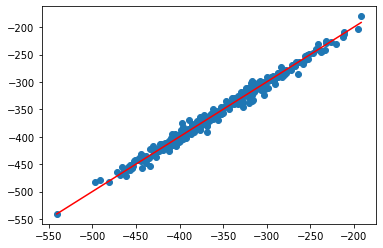

In [65]:
plt.scatter(train_dataset.energies, predicted_e.detach())

x = [torch.min(train_dataset.energies), torch.max(train_dataset.energies)]
plt.plot(x, x, color="r")

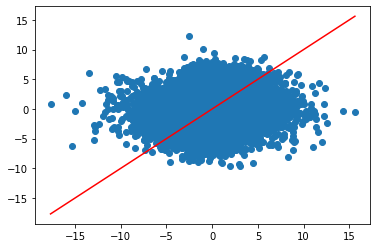

In [66]:
plt.scatter(train_forces.flatten(), predicted_f.detach().flatten())

x = [np.min(train_forces.flatten()), np.max(train_forces.flatten())]
plt.plot(x, x, color="r")

### Testing set

In [67]:
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=512, 
    shuffle=False,
    collate_fn=collate_data_gpu if device == "cuda" else collate_data_cpu
)

In [68]:
test_dataset.zero_positions_grad()
predicted_e = []
for spherical_expansions, species, slices, energies in test_dataloader:
    predicted_e.append(mixed_species_model(spherical_expansions, species, slices))

predicted_e = torch.vstack(predicted_e)


# use backward to predict forces
predicted_e.backward(-torch.ones_like(predicted_e), retain_graph=True)
predicted_f = test_dataset.positions_grad()

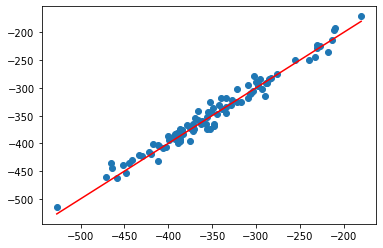

In [69]:
plt.scatter(test_dataset.energies, predicted_e.detach())

x = [torch.min(test_dataset.energies), torch.max(test_dataset.energies)]
plt.plot(x, x, color="r")

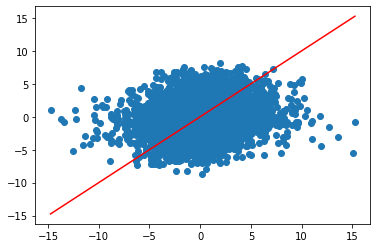

In [70]:
plt.scatter(test_forces.flatten(), predicted_f.detach().flatten())

x = [np.min(test_forces.flatten()), np.max(test_forces.flatten())]
plt.plot(x, x, color="r")